In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import sys
sys.path.append('../')
sys.path.append('../data/')

# M5 Forecasting
This competition (https://www.kaggle.com/c/m5-forecasting-accuracy/overview) aims to forecast Walmart sale forecast daily sales for the next 28 days. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events.

This notebook uses M5 data to demonstrate the time series models:
- seq2seq
- wavenet

## Create data loader

Train and Validation Series Partioning. We need to create 4 sub-segments of the data as the figure below:

1. Train encoding period
2. Train decoding period (train targets, 28 days)
3. Validation encoding period
4. Validation decoding period (validation targets, 28 days)

<img src="fig/web-traffic-train-validation-split.png" width="700" align="left">

### Features
We have 4 kinds of features
- time series: 
    - shape: [nr_ts, len_encode, 1] and [nr_ts, len_decode, 1]
    - current only support 1 dimension. For multivariance time series forecasting, the code in seq2seq.py need to change.
- numerical features: 
    - shape: [nr_ts, len_encode, num_dim] and [nr_ts, len_decode, num_dim]
    - numerical exogenous variable, for example, the daily temprature. In M5 data, we use historical sales (1 year and 3 months ago)
- categorical features
    - shape: [nr_ts, len_encode, cat_dim] and [nr_ts, len_decode, cat_dim]
    - categorical exogenous variable. In M5 data, they are week number, event name, etc
- fixed feature
    - shape: [nr_ts, fixed_feat_dim]
    - fixed features value does not change for the given time series, for example, the store id and state id

In [9]:
from m5_dataloader import *
import torch
from torch.utils.data import DataLoader

input_dir = '../data/M5'

train_encode_decode_boundray = ('2015-03-01', '2016-02-28', '2016-02-29', '2016-03-27')
val_encode_decode_boundray = ('2015-03-29', '2016-03-27', '2016-03-28', '2016-04-24')

categorical_feat_l = ['week_number',
                    'wday',
                    'month',
                    'event_name_1',
                    'event_type_1',
                    'event_name_2',
                    'event_type_2',
                    'snap_CA',
                    'snap_TX',
                    'snap_WI']


fixed_feat_l=['item_id',
            'dept_id',
            'cat_id',
            'store_id',
            'state_id']

xdaysago = [365, 91]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

calendar, sell_prices, sales_train, submission = read_data(input_dir)
sales_train = process_sale_data(sales_train)
processed_calendar = process_calendar(calendar)

train_tuple = get_encode_decode_data(*train_encode_decode_boundray,
                                     sales_train,
                                     calendar,
                                     processed_calendar,
                                     categorical_feat_l,
                                     xdaysago=xdaysago,
                                     is_pred=False)

val_tuple = get_encode_decode_data(*val_encode_decode_boundray,
                                   sales_train,
                                   calendar,
                                   processed_calendar,
                                   categorical_feat_l,
                                   xdaysago=xdaysago,
                                   is_pred=False)

fixed_feat = get_fixed_feat(fixed_feat_l, sales_train)

dataset_train = TSDataset(device, *train_tuple, fixed_feat)

dataset_val = TSDataset(device, *val_tuple, fixed_feat)


INFO:root:Reading files...


Calendar shape: (1969, 14)
Sell prices shape: (6841121, 4)
Sales train shape: (30490, 1919)
Submission shape: (60980, 29)
ts_encode_norm shape torch.Size([30490, 365, 1])
 ts_decode_norm shape torch.Size([30490, 28, 1])
 ts_decode_true shape torch.Size([30490, 28, 1])
 ts_xdaysago_encode shape torch.Size([30490, 365, 2])
 ts_xdaysago_decode shape torch.Size([30490, 28, 2])
 cat_feat_encode shape torch.Size([30490, 365, 10])
 cat_feat_decode shape torch.Size([30490, 28, 10])
 fixed_feat_encode shape torch.Size([30490, 5])
 mean_x shape torch.Size([30490, 1, 1])
 std_x shape torch.Size([30490, 1, 1])

ts_encode_norm shape torch.Size([30490, 365, 1])
 ts_decode_norm shape torch.Size([30490, 28, 1])
 ts_decode_true shape torch.Size([30490, 28, 1])
 ts_xdaysago_encode shape torch.Size([30490, 365, 2])
 ts_xdaysago_decode shape torch.Size([30490, 28, 2])
 cat_feat_encode shape torch.Size([30490, 365, 10])
 cat_feat_decode shape torch.Size([30490, 28, 10])
 fixed_feat_encode shape torch.Size(

In [10]:
from seq2seq import *

BATCH_SIZE = 64
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=0,
                              drop_last=True)

dataloader_val = DataLoader(dataset_val,
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            num_workers=0,
                            drop_last=False)

## Seq2Seq model
The model architecture is as the figure below.
- Feature embedding blocks use 1D convolutional layer and embedding layer to preprocess time series, categorical and fixed features, then concatenate them as one tensor as the input of encoder
- Encoder: use GRU block to learn context vector
- Context enhancement: a linear + tanh transformation layer to enhance the context vector
- Decoder: use GRU block to make time series forecasting

<img src="fig/seq2seq_diagram.png" width="1200" align="left">

### Tensor dimension
the figure below show the input and output size of tensors of each layer

<img src="fig/seq2seq_dimensions.png" width="1200" align="left">

In [11]:
OUTPUT_DIM = 1
CONV1D_OUTPUT_DIM = 4
CONV1D_KERNAL_SIZE = 5
HID_DIM_ENCODE = 128
HID_DIM_DECODE = 128
N_LAYERS_RNN = 2
DROPOUT_RNN = 0.5
FC1_OUT_DIM = 64
FC2_OUT_DIM = 16

categorical_feat_emb_lookup = get_cat_feat_emb_para(categorical_feat_l, processed_calendar)
fixed_feat_emb_lookup = get_fixed_feat_emb_para(fixed_feat_l, sales_train)

model = Seq2Seq(
    device,
    HID_DIM_ENCODE,
    HID_DIM_DECODE,
    N_LAYERS_RNN, 
    DROPOUT_RNN,
    categorical_feat_emb_lookup,
    fixed_feat_emb_lookup,
    xdaysago,
    FC1_OUT_DIM,
    FC2_OUT_DIM,
    CONV1D_OUTPUT_DIM,
    CONV1D_KERNAL_SIZE
)

In [12]:
from torch import optim
from scheduler import OneCycleLR
from train import train, evaluate
from utils import RMSELoss, epoch_time, EarlyStopping
import time

LR = 0.001
N_EPOCHS = 10
CLIP = 2
FORCH_TEACHING_RATE = 0
EARLY_STOP_PATIENT = 10

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = OneCycleLR(optimizer, n_epochs=N_EPOCHS, n_batches=len(dataloader_train))
criterion = RMSELoss()

# initialize the early_stopping object
early_stopping = EarlyStopping(patience=EARLY_STOP_PATIENT, verbose=True)

best_valid_loss = float('inf')
best_epoch_l = []
train_loss_l = []
valid_loss_l = []
valid_loss_orig_l = []

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, dataloader_train, optimizer, scheduler, criterion, CLIP, FORCH_TEACHING_RATE)
    valid_loss, valid_loss_orig = evaluate(model, dataloader_val, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_epoch_l.append(epoch)
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), f'seq2seq.pt')

        
    train_loss_l.append(train_loss)
    valid_loss_l.append(valid_loss)
    valid_loss_orig_l.append(valid_loss_orig)

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model, fold_nr, epoch, optimizer.param_groups[0]['lr'])

    if epoch % 1 == 0:
        print(f'Epoch: {epoch:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.6f}')
        print(f'\t Val. Loss: {valid_loss:.6f}')
        print(f'\t Val. orig Loss: {valid_loss_orig:.6f}')
        lr = optimizer.param_groups[0]['lr']
        print(f'\tLR: {lr}')        

    if early_stopping.early_stop:
        print("Early stopping")
        break  


KeyboardInterrupt: 

### Visualization of the prediction

pred shape (30490, 28)
Visualize time series [1372]
1.1455381049351891


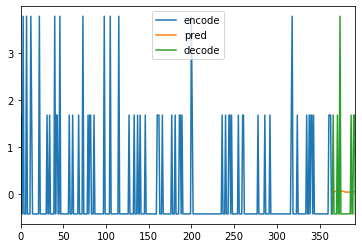

In [37]:
from m5_dataloader import M5_LEN_DECODE, M5_LEN_ENCODE

pred_norm, decode_norm = vis(dataloader_val, model, len_encode=M5_LEN_ENCODE, len_decode=M5_LEN_DECODE, device=device)
loss = np.mean((pred_norm-decode_norm)**2)
print(loss)